In [3]:
# This block of code is to import the packages necessary to run and perform the functions for the rest of the code.
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [31]:
# These are the default parameters used in this model. Some of the hyperparameters given below
# are redefined in a loop so as to vary the respective hyperparameter and plot some graphical changes.
# The redefined hyperparameters below are M_list_iterations, C_Lambda_list_iterations, and scaling_list_iterations(to vary the scaling)
# The hyperparameters defined below are used in the regression model using KMeans Clustering.
maxAcc = 0.0
maxIter = 0
M = 10
M_list_iterations = list(range(1,31))
C_Lambda = 0.03
C_Lambda_list_iterations = np.linspace(0.01,0.15,num = 12)
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
scaling_list_iterations = np.linspace(100,350,num = 15)
PHI = []
IsSynthetic = False

## Default Function

In [32]:
# These functions are defined so as to make the code less complicated while executing the model.

# The GetTargetVector function is used to import the csv file containing the target values.
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

# The GenerateRawData function is used to import the csv file containing the feature values.
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

# The GenerateTrainingTarget function, to classify 80% the target data set as the training target set.
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

# The GenerateTrainingDataMatrix function, to classify 80% the raw feature data set as the training feature set.
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

# The GenerateValData function, to classify 10% the raw feature data set as the validation feature set.
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

# The GenerateValTargetVector function, to classify 10% the target data set as the validation target set.
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

# The GenerateBigSigma function is used to generate the variance of the basis function
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x


def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI


def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

# The GetErms function has the formula of Erms defined in it, so it just has to be called in the model to get
# the Erms values.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [33]:
# As the title says, these lines of code are used to fetch the target and feature data sets using the functions.
# IsSynthetic is used to determine whether the data is synthetic or not.
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 'U' mode is deprecated
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 'U' mode is deprecated


In [34]:
len(RawTarget)
RawData.shape

(41, 69623)

## Prepare Training Data

In [35]:
# With the help of the functions and numpy, the training target and training feature sets are put into an array.
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [36]:
# With the help of the functions and numpy, the validation target and training feature sets are put into an array.
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [37]:
# With the help of the functions and numpy, the testing target and training feature sets are put into an array.
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

### FIRST CASE: Hyperparameters set to default, as given in the code

In [38]:
# Using all the functions created above, KMeans clustering is done, in which, for a fixed M value,
# random Mu values are generated(these are data points from the set of feature values itself which
# are taken as the centroids of the clusters). Over here, M is the number of radial basis functions.
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [39]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 41)
(41, 41)
(55699, 10)
(10,)
(6962, 10)
(6961, 10)


## Finding Erms on training, validation and test set 

In [41]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [88]:
print ('UBITname      = yashahuj')
print ('Person Number = 50245092')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 10 \nLambda = 0.9")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

UBITname      = yashahuj
Person Number = 50245092
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.5471601983706641
E_rms Validation = 0.5371221949411772
E_rms Testing    = 0.6271127363319977


### SECOND CASE : When all the hyperparameters are default, but M

In [43]:
# The following is a modified code of the above model, varying the values of M.
# In other words, KMeans Clustering is repeated, but only with varying the values of M and keeping the rest 
# of the hyperparameters at its default values.
ErmsArr = []
for i in range(len(M_list_iterations)):
    kmeans = KMeans(n_clusters=M_list_iterations[i], random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_
    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    W_M          = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W_M)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W_M)
    TEST_OUT     = GetValTest(TEST_PHI,W_M)
    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    ERMS = float(ValidationAccuracy.split(',')[1])
    ErmsArr.append(ERMS)
ErmsArr

[0.5543829496065422,
 0.5509381914793687,
 0.5415076264468829,
 0.5415267007082193,
 0.5410872787323602,
 0.5408438307585555,
 0.5405036694096224,
 0.5408406972910149,
 0.5397496349174215,
 0.5384281741389029,
 0.5384214251555269,
 0.5389487099452899,
 0.5379257255209654,
 0.538713084833012,
 0.537463214291947,
 0.537007312949483,
 0.5383833992262116,
 0.5381800093891457,
 0.5382616139520234,
 0.5383600398443413,
 0.5381340133388601,
 0.5381366839689677,
 0.5378009176694595,
 0.537889614193768,
 0.5377070882431654,
 0.5379954576709503,
 0.5371886808845491,
 0.5374143343913512,
 0.5370526103866959,
 0.5371800811959156]

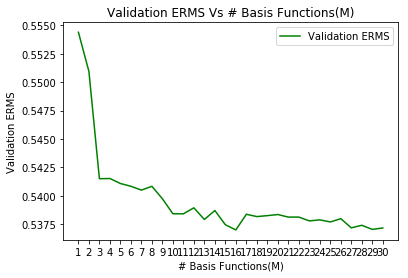

In [44]:
# Plotting the results of the variable M values(X-Axis) versus its respective Validation ERMS(Y-Axis)
plt.title('Validation ERMS Vs # Basis Functions(M)')
plt.plot(M_list_iterations,ErmsArr,'g-', label = 'Validation ERMS')
matplotlib.pyplot.xticks(M_list_iterations)
plt.ylabel('Validation ERMS')
plt.xlabel("# Basis Functions(M)")
plt.legend()
#plt.savefig('Varying_M.pdf')
#plt.savefig('Varying_M.png')

### THIRD CASE : When all the hyperparameters are default, but the Lambda value(C_Lambda)

In [45]:
# The following is a modified code of the above model, varying the values of C_Lambda.
# In other words, KMeans Clustering is repeated, but only with varying the values of C_Lambda and keeping the rest 
# of the hyperparameters at its default values.
ErmsArr_CL = []
for i in range(len(C_Lambda_list_iterations)):
    kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_
    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    W_C            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda_list_iterations[i])) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W_C)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W_C)
    TEST_OUT     = GetValTest(TEST_PHI,W_C)
    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    ERMS = float(ValidationAccuracy.split(',')[1])
    ErmsArr_CL.append(ERMS)
ErmsArr_CL

[0.5384211743826103,
 0.5384232233421563,
 0.5384329868081171,
 0.5384465981009393,
 0.5384622396549463,
 0.5384789657652691,
 0.5384962459152811,
 0.5385137651839507,
 0.5385313285657874,
 0.538548811575324,
 0.5385661331460415,
 0.538583239979305]

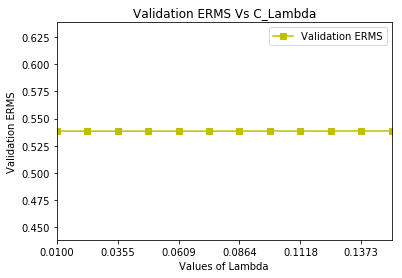

In [60]:
# Plotting the results of the variable C_Lambda values(X-Axis) versus its respective Validation ERMS(Y-Axis)
plt.title('Validation ERMS Vs C_Lambda')
plt.plot(C_Lambda_list_iterations,ErmsArr_CL,'ys-', label = 'Validation ERMS')
matplotlib.pyplot.xticks(C_Lambda_list_iterations)
plt.axis([min(C_Lambda_list_iterations), max(C_Lambda_list_iterations), min(ErmsArr_CL)-0.1, max(ErmsArr_CL)+0.1])
plt.ylabel('Validation ERMS')
plt.locator_params(nbins=10, axis='x')
plt.xlabel("Values of Lambda")
p = plt.legend()
#plt.savefig('Varying_CL.pdf')
#plt.savefig('Varying_CL.png')

In [47]:
# Redefining the functions that require different function names in order to avoid confusion to run
# the next part of the model smoothly.
def GenerateBigSigma_SF(Data, MuMatrix,TrainingPercent,IsSynthetic,scaling_list_iterations):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(scaling_list_iterations,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar_SF(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut_SF(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix_SF(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm_SF(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix_SF(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest_SF(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms_SF(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

### FOURTH CASE : When all the hyperparameters are default, but the scaling for Big Sigma

In [48]:
# The following is a modified code of the above model, varying the scale of Big Sigma.
# In other words, KMeans Clustering is repeated, but only with varying the scale of Big Sigma and keeping the rest 
# of the hyperparameters at its default values.
ErmsArr_SF = []
for i in range(len(scaling_list_iterations)):
    kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
    Mu_SF = kmeans.cluster_centers_
    BigSigma_SF     = GenerateBigSigma_SF(RawData, Mu_SF, TrainingPercent,IsSynthetic,scaling_list_iterations[i])
    TRAINING_PHI_SF = GetPhiMatrix_SF(RawData, Mu_SF, BigSigma_SF, TrainingPercent)
    W_SF            = GetWeightsClosedForm_SF(TRAINING_PHI_SF,TrainingTarget,(C_Lambda)) 
    TEST_PHI_SF     = GetPhiMatrix_SF(TestData, Mu_SF, BigSigma_SF, 100) 
    VAL_PHI_SF      = GetPhiMatrix_SF(ValData, Mu_SF, BigSigma_SF, 100)
    TR_TEST_OUT_SF  = GetValTest_SF(TRAINING_PHI_SF,W_SF)
    VAL_TEST_OUT_SF = GetValTest_SF(VAL_PHI_SF,W_SF)
    TEST_OUT_SF     = GetValTest_SF(TEST_PHI_SF,W_SF)
    TrainingAccuracy_SF   = str(GetErms_SF(TR_TEST_OUT_SF,TrainingTarget))
    ValidationAccuracy_SF = str(GetErms_SF(VAL_TEST_OUT_SF,ValDataAct))
    TestAccuracy_SF      = str(GetErms_SF(TEST_OUT_SF,TestDataAct))
    ERMS_SF = float(ValidationAccuracy.split(',')[1])
    ErmsArr_SF.append(ERMS_SF)
ErmsArr_SF

[0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305,
 0.538583239979305]

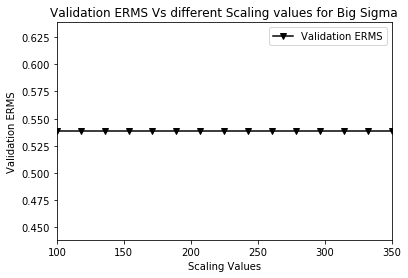

In [51]:
# Plotting the results of the variable scaling values(X-Axis) versus its respective Validation ERMS(Y-Axis)
plt.title('Validation ERMS Vs different Scaling values for Big Sigma')
plt.plot(scaling_list_iterations,ErmsArr_SF,'kv-', label='Validation ERMS')
plt.axis([min(scaling_list_iterations), max(scaling_list_iterations), min(ErmsArr_SF)-0.1, max(ErmsArr_SF)+0.1])
plt.ylabel('Validation ERMS')
plt.xlabel("Scaling Values")
l = plt.legend()
#plt.savefig('Varying_SF.pdf')
#plt.savefig('Varying_SF.png')

## Results with the best hyperparameters on the testing set(Closed-Form Solution)

In [70]:
M_new= 16
C_Lambda_new = 0.01

kmeans = KMeans(n_clusters=M_new, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda_new)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)
TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy      = str(GetErms(TEST_OUT,TestDataAct))
ERMS_Test1 = float(TestAccuracy.split(',')[1])
ERMS_Test1

0.6271127363319977

## Gradient Descent solution for Linear Regression

In [105]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


### FIFTH CASE : Hyperparameters set to default, as given in the code(Gradient Descent)

In [61]:
# The following code is run for the default values of the hyperparameters (learningRate and Lambda).
# The empty lists created will have an appended list of Erms values for the training, validation,
# and the testing data respectively.

W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

# This loop is used as iterations to update the new weight values
for i in range(0,400):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [62]:
# This code is used to print out the results of the above Gradient descent model with default values of
# hyperparameters
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.54964
E_rms Validation = 0.53846
E_rms Testing    = 0.62372


### SIXTH CASE : When all the hyperparameters are default, but learning rate(Gradient Descent)

In [83]:
# This is the same code as the above GD model, with the only change in the learning rate. The learning rate
# is looped in order to get a list learning rate values to plot the variable change versus the validation Erms.
W_Now        = np.dot(220, W)
La           = 2
#learningRate = 0.01
learningRate_list_iterations = np.linspace(0.01,0.05,num = 10)
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Erms_Val_new = []

# To get one value of Erms for each learning rate, we create another loop and only take the last value from the 
# list of Validation Erms.
for j in range(len(learningRate_list_iterations)):
    for i in range(0,400):
    
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate_list_iterations[j],Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next
    
        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Erms_Val_new.append(L_Erms_Val[-1])

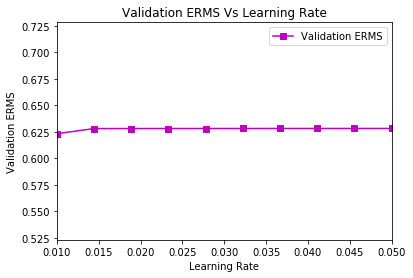

In [84]:
# Plotting the results of the variable learning rate values(X-Axis) versus its respective Validation ERMS(Y-Axis)
plt.title('Validation ERMS Vs Learning Rate')
plt.plot(learningRate_list_iterations,L_Erms_Val_new,'ms-', label='Validation ERMS')
plt.axis([min(learningRate_list_iterations), max(learningRate_list_iterations), min(L_Erms_Val_new)-0.1, max(L_Erms_Val_new)+0.1])
plt.ylabel('Validation ERMS')
plt.xlabel('Learning Rate')
l = plt.legend()
#plt.savefig('Varying_eta.pdf')
#plt.savefig('Varying_eta.png')

### SEVENTH CASE : When all the hyperparameters are default, but the Lambda value(Gradient Descent)

In [85]:
# This is the same code as the above GD model, with the only change in the lambda value. The lambda value
# is looped in order to get a list lambda values to plot the variable change versus the validation Erms.

W_Now        = np.dot(220, W)
#La           = 2
learningRate = 0.01
La_list_iterations = np.linspace(1,10,num = 10)
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
L_Erms_Val_new = []

for j in range(len(La_list_iterations)):
    for i in range(0,400):
    
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La_list_iterations[j],W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next
    
        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Erms_Val_new.append(L_Erms_Val[-1])

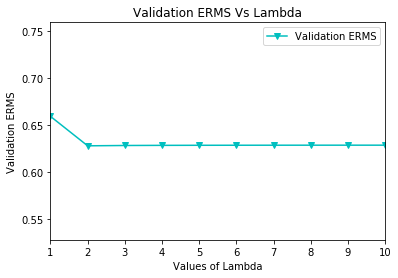

In [86]:
# Plotting the results of the variable lambda  values(X-Axis) versus its respective Validation ERMS(Y-Axis)
plt.title('Validation ERMS Vs Lambda')
plt.plot(La_list_iterations,L_Erms_Val_new,'cv-', label='Validation ERMS')
plt.axis([min(La_list_iterations), max(La_list_iterations), min(L_Erms_Val_new)-0.1, max(L_Erms_Val_new)+0.1])
plt.ylabel('Validation ERMS')
plt.xlabel("Values of Lambda")
l = plt.legend()
#plt.savefig('Varying_lambda.pdf')
#plt.savefig('Varying_lambda.png')

## Results with the best hyperparameters on the testing set(Gradient Descent)

In [87]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

# This loop is used as iterations to update the new weight values
for i in range(0,400):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

E_rms Testing    = 0.62299
